# Import Libraries

In [1]:
import utils
import numpy as np
from scipy.linalg import expm, sinm, cosm
#%matplotlib qt

# Prepare Data

In [2]:
datasetName="data/10.npz"
dataTuple=utils.load_data(datasetName, True)

In [3]:
times=dataTuple[0].reshape(-1)
print("times:", times,"\nshape:", times.shape)

times: [1.36974249e+09 1.36974249e+09 1.36974249e+09 ... 1.36974280e+09
 1.36974280e+09 1.36974280e+09] 
shape: (3026,)


In [4]:
features=dataTuple[1]
print(features.shape)

(4, 13289, 3026)


In [5]:
v=dataTuple[2]
print(v.shape)

(3, 3026)


In [6]:
omega=dataTuple[3]
print(omega.shape)

(3, 3026)


In [7]:
K=dataTuple[4]
print(K)

[[552.554261   0.       682.049453]
 [  0.       552.554261 238.769549]
 [  0.         0.         1.      ]]


In [8]:
b=dataTuple[5]
print(b)

0.6


# Parameters

### time

In [9]:
endtime=len(times)
#endtime=600

### pose

In [10]:
mu_T_initial= np.eye(4)

mu_T=np.zeros((4,4))
mu_T=mu_T_initial

sigma_T=np.zeros(0)
poses=np.zeros((4,4,endtime))
poses[:,:,0]=mu_T_initial

### map

In [11]:
mu_M=np.zeros((3,0))
sigma_M=np.zeros((0,0))
landmarkOrdering=[]
#V=np.mean(np.mean(allObservations))/100
initialVar_M=0.1

### Camera

In [12]:
P=np.zeros((3,4))
P[0:3,0:3]=np.eye(3)
print(P)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [13]:
i_T_o=(dataTuple[6])
print(i_T_o)

[[ 0.03717833 -0.09861822  0.9944306   1.5752681 ]
 [ 0.99926755 -0.00535534 -0.03789026  0.00439141]
 [ 0.00906218  0.99511094  0.09834688 -0.65      ]
 [ 0.          0.          0.          1.        ]]


In [14]:
o_T_i=np.linalg.inv(dataTuple[6])
print(o_T_i)

[[ 0.03717833  0.99926756  0.00906218 -0.05706361]
 [-0.09861821 -0.00535534  0.99511093  0.80219574]
 [ 0.9944306  -0.03789026  0.09834688 -1.50240294]
 [ 0.          0.          0.          1.        ]]


In [15]:
M=np.array([np.append(K[0,:],0),np.append(K[1,:],0),np.append(K[0,:], -K[0][0]*b),np.append(K[1,:],0)])
print(M.shape)
print(M)

(4, 4)
[[ 552.554261     0.         682.049453     0.       ]
 [   0.         552.554261   238.769549     0.       ]
 [ 552.554261     0.         682.049453  -331.5325566]
 [   0.         552.554261   238.769549     0.       ]]


In [16]:
K

array([[552.554261,   0.      , 682.049453],
       [  0.      , 552.554261, 238.769549],
       [  0.      ,   0.      ,   1.      ]])

# Helper Functions

### pi Projection

In [17]:
def piProjection(mat):
    projection=np.zeros((mat.shape[0],mat.shape[1]))
    for i in range(projection.shape[1]):
        vec=mat[:,i]
        vec=vec/vec[2]
        projection[:,i]=vec
    return projection

### derivative pi Projection

In [18]:
def derivative_piProjection(vec):
    derivativeProjection=np.array([[1,0,-vec[0]/vec[2],0],[0,1,-vec[1]/vec[2],0],[0,0,0,0],[0,0,-vec[3]/vec[2],1]])
    return derivativeProjection

### Hat Map

In [19]:
def hatmap(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array([[0, -vector[2], vector[1]], 
                     [vector[2], 0, -vector[0]], 
                     [-vector[1], vector[0], 0]])

### Compute Jacobians

In [20]:
def jacobian(mu_M_observed_copy,timeFrame,validAlreadySeen_OrderingIndices):
    jacobian=np.zeros((4*mu_M_observed_copy.shape[1], 3*mu_M.shape[1]))
    #getMatrix for each obeservation, then initialize that part of jacobian. 
    for j in range(len(validAlreadySeen_OrderingIndices)):
        indices=np.array([j,validAlreadySeen_OrderingIndices[j]])
        topLeftCorner=np.array([4*indices[0], 3*indices[1]])
        H_sub=M@derivative_piProjection(o_T_i@np.linalg.inv(mu_T)@mu_M_observed_copy[:,j])@o_T_i@np.linalg.inv(mu_T)@np.transpose(P)
        jacobian[topLeftCorner[0]:topLeftCorner[0]+4,topLeftCorner[1]:topLeftCorner[1]+3] = H_sub
    return jacobian

### Landmark Ordering Indices

In [21]:
def getLandmarkOrderingIndices(validAlreadySeen):
    indices=[]
    for i in range(len(validAlreadySeen)):
        mu_column_ind=np.where(validAlreadySeen[i]==landmarkOrdering)[0][0]
        indices.append(mu_column_ind)
    return indices

### Camera to World

In [22]:
fsu=K[0,0]
fsv=K[1,1]
cu=K[0,2]
cv=K[1,2]
o_R_r=np.array([[0,-1,0],[0,0,-1],[1,0,0]])

In [23]:
o_R_r[:2,:2]

array([[ 0, -1],
       [ 0,  0]])

In [24]:
features[:,:,0][:,0]

array([161.05625916,  29.7433033 , 148.27815247,  30.20702744])

In [26]:
def initializeMu_M(validFirstSeenObservations):
    global mu_T
    worldFrameProjections=np.zeros((3,validFirstSeenObservations.shape[1]))
    for i in range(validFirstSeenObservations.shape[1]):
        [u_L, v_L, u_R, v_R]=validFirstSeenObservations[:,i]
        d=u_L-u_R
        z= fsu*b/d
        y= (v_L*z-cv*z)/fsv
        x= (u_L*z-cu*z)/fsu
        vec=[x,y,z]
        W_T_I= mu_T@i_T_o
        p= W_T_I[[0,1,2],3]
        R= W_T_I[:3,:3]
        m=R@np.linalg.inv(o_R_r)@vec+p
        worldFrameProjections[:,i] = (mu_T@i_T_o@[x,y,z,1])[:3]
        #print("m:", m)
    return worldFrameProjections

# EKF Pose Prediction

In [27]:
def prediction(timeIndex):
    global mu_T
    tau=times[timeIndex]-times[timeIndex-1]
    v_t=v[:,timeIndex-1]
    omega_t=omega[:,timeIndex-1]
    omega_hat_t= hatmap(omega_t)
    
    u_hat= np.block([
    [omega_hat_t,            v_t.reshape(3,1)],
    [np.zeros((1, 3)),             0]
    ])
    
    mu_T=mu_T@expm(tau*u_hat)
    poses[:,:,timeIndex]=mu_T

# Visual Mapping EKF Update

In [28]:
def mappingUpdate(timeFrame):
    global mu_M
    global sigma_M
    global landmarkOrdering
    
    features_curr=features[:,:,timeFrame]
    
    validObservationIndices=np.where(features_curr[0,:] != -1)[0]
    validAlreadySeen=np.intersect1d(validObservationIndices,landmarkOrdering)
    validAlreadySeen_OrderingIndices=getLandmarkOrderingIndices(validAlreadySeen)

    if(len(validAlreadySeen)>0):
        z_actual= features_curr[:,validAlreadySeen]
        mu_M_validAlreadySeen=mu_M[:,validAlreadySeen_OrderingIndices]
        mu_M_validAlreadySeen_homogeneous= np.vstack((mu_M_validAlreadySeen, np.ones(len(validAlreadySeen))))

        z_predicted = M@piProjection(o_T_i@np.linalg.inv(mu_T)@ mu_M_validAlreadySeen_homogeneous)

        innovation=np.reshape(z_actual-z_predicted,(-1))
        H=jacobian(mu_M_validAlreadySeen_homogeneous,timeFrame, validAlreadySeen_OrderingIndices)
        K=sigma_M@np.transpose(H)@np.linalg.inv(H@sigma_M@np.transpose(H)+ 8*np.eye(H.shape[0]))
        mu_M = (mu_M.reshape(-1)+ K@(innovation.reshape(-1))).reshape(3,-1)
        sigma_M=(np.eye(3*mu_M.shape[1])-K@H)@sigma_M
    
    validFirstSeen = np.setdiff1d(validObservationIndices, landmarkOrdering)    
    validFirstSeen=validFirstSeen.astype(int).tolist()
    for el in validFirstSeen:
        landmarkOrdering.append(el)
    if(len(validFirstSeen)>0):
        validFirstSeenObservations=features_curr[:, validFirstSeen]
        newMus=initializeMu_M(validFirstSeenObservations)
        mu_M=np.hstack((mu_M,newMus))
        sigma_M_endCorner=sigma_M.shape[0]
        sigma_M=np.pad(sigma_M, [(0, len(validFirstSeen)*3), (0, len(validFirstSeen)*3)], mode='constant')
        for i in range(sigma_M_endCorner,sigma_M_endCorner+3*len(validFirstSeen)):
            sigma_M[i,i]=initialVar_M

# Main Loop

In [29]:
for i in range(1,endtime):
    print("iter:", i, "mu_M shape:", mu_M.shape)
    prediction(i)
    mappingUpdate(i)

iter: 1 mu_M shape: (3, 0)
iter: 2 mu_M shape: (3, 56)
iter: 3 mu_M shape: (3, 56)
iter: 4 mu_M shape: (3, 56)
iter: 5 mu_M shape: (3, 56)
iter: 6 mu_M shape: (3, 56)
iter: 7 mu_M shape: (3, 56)
iter: 8 mu_M shape: (3, 56)
iter: 9 mu_M shape: (3, 56)
iter: 10 mu_M shape: (3, 56)
iter: 11 mu_M shape: (3, 56)
iter: 12 mu_M shape: (3, 56)
iter: 13 mu_M shape: (3, 56)
iter: 14 mu_M shape: (3, 56)
iter: 15 mu_M shape: (3, 56)
iter: 16 mu_M shape: (3, 56)
iter: 17 mu_M shape: (3, 56)
iter: 18 mu_M shape: (3, 131)
iter: 19 mu_M shape: (3, 131)
iter: 20 mu_M shape: (3, 131)
iter: 21 mu_M shape: (3, 131)
iter: 22 mu_M shape: (3, 131)
iter: 23 mu_M shape: (3, 131)
iter: 24 mu_M shape: (3, 131)
iter: 25 mu_M shape: (3, 131)
iter: 26 mu_M shape: (3, 131)
iter: 27 mu_M shape: (3, 131)
iter: 28 mu_M shape: (3, 131)
iter: 29 mu_M shape: (3, 131)
iter: 30 mu_M shape: (3, 131)
iter: 31 mu_M shape: (3, 131)
iter: 32 mu_M shape: (3, 131)
iter: 33 mu_M shape: (3, 131)
iter: 34 mu_M shape: (3, 131)
iter: 3

iter: 269 mu_M shape: (3, 1266)
iter: 270 mu_M shape: (3, 1266)
iter: 271 mu_M shape: (3, 1266)
iter: 272 mu_M shape: (3, 1266)
iter: 273 mu_M shape: (3, 1266)
iter: 274 mu_M shape: (3, 1266)
iter: 275 mu_M shape: (3, 1266)
iter: 276 mu_M shape: (3, 1266)
iter: 277 mu_M shape: (3, 1266)
iter: 278 mu_M shape: (3, 1266)
iter: 279 mu_M shape: (3, 1266)
iter: 280 mu_M shape: (3, 1266)
iter: 281 mu_M shape: (3, 1370)
iter: 282 mu_M shape: (3, 1370)
iter: 283 mu_M shape: (3, 1370)
iter: 284 mu_M shape: (3, 1370)
iter: 285 mu_M shape: (3, 1370)
iter: 286 mu_M shape: (3, 1370)
iter: 287 mu_M shape: (3, 1370)
iter: 288 mu_M shape: (3, 1370)
iter: 289 mu_M shape: (3, 1370)
iter: 290 mu_M shape: (3, 1370)
iter: 291 mu_M shape: (3, 1370)
iter: 292 mu_M shape: (3, 1370)
iter: 293 mu_M shape: (3, 1435)
iter: 294 mu_M shape: (3, 1435)
iter: 295 mu_M shape: (3, 1435)
iter: 296 mu_M shape: (3, 1435)
iter: 297 mu_M shape: (3, 1435)
iter: 298 mu_M shape: (3, 1435)
iter: 299 mu_M shape: (3, 1435)
iter: 30

iter: 532 mu_M shape: (3, 2471)
iter: 533 mu_M shape: (3, 2471)
iter: 534 mu_M shape: (3, 2497)
iter: 535 mu_M shape: (3, 2497)
iter: 536 mu_M shape: (3, 2497)
iter: 537 mu_M shape: (3, 2497)
iter: 538 mu_M shape: (3, 2497)
iter: 539 mu_M shape: (3, 2497)
iter: 540 mu_M shape: (3, 2497)
iter: 541 mu_M shape: (3, 2497)
iter: 542 mu_M shape: (3, 2531)
iter: 543 mu_M shape: (3, 2531)
iter: 544 mu_M shape: (3, 2531)
iter: 545 mu_M shape: (3, 2531)
iter: 546 mu_M shape: (3, 2531)
iter: 547 mu_M shape: (3, 2531)
iter: 548 mu_M shape: (3, 2531)
iter: 549 mu_M shape: (3, 2531)
iter: 550 mu_M shape: (3, 2531)
iter: 551 mu_M shape: (3, 2531)
iter: 552 mu_M shape: (3, 2531)
iter: 553 mu_M shape: (3, 2531)
iter: 554 mu_M shape: (3, 2531)
iter: 555 mu_M shape: (3, 2531)
iter: 556 mu_M shape: (3, 2531)
iter: 557 mu_M shape: (3, 2531)
iter: 558 mu_M shape: (3, 2531)
iter: 559 mu_M shape: (3, 2597)
iter: 560 mu_M shape: (3, 2597)
iter: 561 mu_M shape: (3, 2597)
iter: 562 mu_M shape: (3, 2597)
iter: 56

iter: 790 mu_M shape: (3, 3704)
iter: 791 mu_M shape: (3, 3704)
iter: 792 mu_M shape: (3, 3704)
iter: 793 mu_M shape: (3, 3704)
iter: 794 mu_M shape: (3, 3704)
iter: 795 mu_M shape: (3, 3704)
iter: 796 mu_M shape: (3, 3704)
iter: 797 mu_M shape: (3, 3704)
iter: 798 mu_M shape: (3, 3704)
iter: 799 mu_M shape: (3, 3734)
iter: 800 mu_M shape: (3, 3734)
iter: 801 mu_M shape: (3, 3734)
iter: 802 mu_M shape: (3, 3734)
iter: 803 mu_M shape: (3, 3734)
iter: 804 mu_M shape: (3, 3734)
iter: 805 mu_M shape: (3, 3734)
iter: 806 mu_M shape: (3, 3734)
iter: 807 mu_M shape: (3, 3734)
iter: 808 mu_M shape: (3, 3734)
iter: 809 mu_M shape: (3, 3734)
iter: 810 mu_M shape: (3, 3764)
iter: 811 mu_M shape: (3, 3764)
iter: 812 mu_M shape: (3, 3764)
iter: 813 mu_M shape: (3, 3764)
iter: 814 mu_M shape: (3, 3764)
iter: 815 mu_M shape: (3, 3764)
iter: 816 mu_M shape: (3, 3764)
iter: 817 mu_M shape: (3, 3764)
iter: 818 mu_M shape: (3, 3791)
iter: 819 mu_M shape: (3, 3791)
iter: 820 mu_M shape: (3, 3791)
iter: 82

iter: 1049 mu_M shape: (3, 5062)
iter: 1050 mu_M shape: (3, 5062)
iter: 1051 mu_M shape: (3, 5070)
iter: 1052 mu_M shape: (3, 5070)
iter: 1053 mu_M shape: (3, 5070)
iter: 1054 mu_M shape: (3, 5084)
iter: 1055 mu_M shape: (3, 5084)
iter: 1056 mu_M shape: (3, 5095)
iter: 1057 mu_M shape: (3, 5095)
iter: 1058 mu_M shape: (3, 5095)
iter: 1059 mu_M shape: (3, 5112)
iter: 1060 mu_M shape: (3, 5112)
iter: 1061 mu_M shape: (3, 5112)
iter: 1062 mu_M shape: (3, 5129)
iter: 1063 mu_M shape: (3, 5129)
iter: 1064 mu_M shape: (3, 5129)
iter: 1065 mu_M shape: (3, 5141)
iter: 1066 mu_M shape: (3, 5141)
iter: 1067 mu_M shape: (3, 5141)
iter: 1068 mu_M shape: (3, 5156)
iter: 1069 mu_M shape: (3, 5156)
iter: 1070 mu_M shape: (3, 5156)
iter: 1071 mu_M shape: (3, 5179)
iter: 1072 mu_M shape: (3, 5179)
iter: 1073 mu_M shape: (3, 5179)
iter: 1074 mu_M shape: (3, 5179)
iter: 1075 mu_M shape: (3, 5198)
iter: 1076 mu_M shape: (3, 5198)
iter: 1077 mu_M shape: (3, 5198)
iter: 1078 mu_M shape: (3, 5198)
iter: 1079

iter: 1299 mu_M shape: (3, 6746)
iter: 1300 mu_M shape: (3, 6746)
iter: 1301 mu_M shape: (3, 6746)
iter: 1302 mu_M shape: (3, 6746)
iter: 1303 mu_M shape: (3, 6746)
iter: 1304 mu_M shape: (3, 6746)
iter: 1305 mu_M shape: (3, 6746)
iter: 1306 mu_M shape: (3, 6746)
iter: 1307 mu_M shape: (3, 6746)
iter: 1308 mu_M shape: (3, 6786)
iter: 1309 mu_M shape: (3, 6786)
iter: 1310 mu_M shape: (3, 6786)
iter: 1311 mu_M shape: (3, 6786)
iter: 1312 mu_M shape: (3, 6786)
iter: 1313 mu_M shape: (3, 6786)
iter: 1314 mu_M shape: (3, 6786)
iter: 1315 mu_M shape: (3, 6846)
iter: 1316 mu_M shape: (3, 6846)
iter: 1317 mu_M shape: (3, 6846)
iter: 1318 mu_M shape: (3, 6846)
iter: 1319 mu_M shape: (3, 6846)
iter: 1320 mu_M shape: (3, 6846)
iter: 1321 mu_M shape: (3, 6846)
iter: 1322 mu_M shape: (3, 6846)
iter: 1323 mu_M shape: (3, 6846)
iter: 1324 mu_M shape: (3, 6893)
iter: 1325 mu_M shape: (3, 6893)
iter: 1326 mu_M shape: (3, 6893)
iter: 1327 mu_M shape: (3, 6893)
iter: 1328 mu_M shape: (3, 6893)
iter: 1329

iter: 1551 mu_M shape: (3, 7686)
iter: 1552 mu_M shape: (3, 7686)
iter: 1553 mu_M shape: (3, 7686)
iter: 1554 mu_M shape: (3, 7686)
iter: 1555 mu_M shape: (3, 7686)
iter: 1556 mu_M shape: (3, 7686)
iter: 1557 mu_M shape: (3, 7686)
iter: 1558 mu_M shape: (3, 7686)
iter: 1559 mu_M shape: (3, 7686)
iter: 1560 mu_M shape: (3, 7686)
iter: 1561 mu_M shape: (3, 7686)
iter: 1562 mu_M shape: (3, 7756)
iter: 1563 mu_M shape: (3, 7756)
iter: 1564 mu_M shape: (3, 7756)
iter: 1565 mu_M shape: (3, 7756)
iter: 1566 mu_M shape: (3, 7756)
iter: 1567 mu_M shape: (3, 7756)
iter: 1568 mu_M shape: (3, 7756)
iter: 1569 mu_M shape: (3, 7841)
iter: 1570 mu_M shape: (3, 7841)
iter: 1571 mu_M shape: (3, 7841)
iter: 1572 mu_M shape: (3, 7841)
iter: 1573 mu_M shape: (3, 7841)
iter: 1574 mu_M shape: (3, 7841)
iter: 1575 mu_M shape: (3, 7841)
iter: 1576 mu_M shape: (3, 7841)
iter: 1577 mu_M shape: (3, 7841)
iter: 1578 mu_M shape: (3, 7841)
iter: 1579 mu_M shape: (3, 7841)
iter: 1580 mu_M shape: (3, 7841)
iter: 1581

iter: 1806 mu_M shape: (3, 9016)
iter: 1807 mu_M shape: (3, 9016)
iter: 1808 mu_M shape: (3, 9016)
iter: 1809 mu_M shape: (3, 9016)
iter: 1810 mu_M shape: (3, 9016)
iter: 1811 mu_M shape: (3, 9016)
iter: 1812 mu_M shape: (3, 9077)
iter: 1813 mu_M shape: (3, 9077)
iter: 1814 mu_M shape: (3, 9077)
iter: 1815 mu_M shape: (3, 9077)
iter: 1816 mu_M shape: (3, 9077)
iter: 1817 mu_M shape: (3, 9077)
iter: 1818 mu_M shape: (3, 9077)
iter: 1819 mu_M shape: (3, 9077)
iter: 1820 mu_M shape: (3, 9077)
iter: 1821 mu_M shape: (3, 9077)
iter: 1822 mu_M shape: (3, 9077)
iter: 1823 mu_M shape: (3, 9077)
iter: 1824 mu_M shape: (3, 9077)
iter: 1825 mu_M shape: (3, 9139)
iter: 1826 mu_M shape: (3, 9139)
iter: 1827 mu_M shape: (3, 9139)
iter: 1828 mu_M shape: (3, 9139)
iter: 1829 mu_M shape: (3, 9139)
iter: 1830 mu_M shape: (3, 9139)
iter: 1831 mu_M shape: (3, 9139)
iter: 1832 mu_M shape: (3, 9139)
iter: 1833 mu_M shape: (3, 9139)
iter: 1834 mu_M shape: (3, 9139)
iter: 1835 mu_M shape: (3, 9163)
iter: 1836

iter: 2053 mu_M shape: (3, 10194)
iter: 2054 mu_M shape: (3, 10194)
iter: 2055 mu_M shape: (3, 10194)
iter: 2056 mu_M shape: (3, 10194)
iter: 2057 mu_M shape: (3, 10194)
iter: 2058 mu_M shape: (3, 10194)
iter: 2059 mu_M shape: (3, 10194)
iter: 2060 mu_M shape: (3, 10194)
iter: 2061 mu_M shape: (3, 10194)
iter: 2062 mu_M shape: (3, 10252)
iter: 2063 mu_M shape: (3, 10252)
iter: 2064 mu_M shape: (3, 10252)
iter: 2065 mu_M shape: (3, 10252)
iter: 2066 mu_M shape: (3, 10252)
iter: 2067 mu_M shape: (3, 10252)
iter: 2068 mu_M shape: (3, 10301)
iter: 2069 mu_M shape: (3, 10301)
iter: 2070 mu_M shape: (3, 10301)
iter: 2071 mu_M shape: (3, 10301)
iter: 2072 mu_M shape: (3, 10301)
iter: 2073 mu_M shape: (3, 10301)
iter: 2074 mu_M shape: (3, 10301)
iter: 2075 mu_M shape: (3, 10301)
iter: 2076 mu_M shape: (3, 10301)
iter: 2077 mu_M shape: (3, 10357)
iter: 2078 mu_M shape: (3, 10357)
iter: 2079 mu_M shape: (3, 10357)
iter: 2080 mu_M shape: (3, 10357)
iter: 2081 mu_M shape: (3, 10357)
iter: 2082 mu_

iter: 2295 mu_M shape: (3, 11022)
iter: 2296 mu_M shape: (3, 11022)
iter: 2297 mu_M shape: (3, 11022)
iter: 2298 mu_M shape: (3, 11022)
iter: 2299 mu_M shape: (3, 11022)
iter: 2300 mu_M shape: (3, 11022)
iter: 2301 mu_M shape: (3, 11022)
iter: 2302 mu_M shape: (3, 11022)
iter: 2303 mu_M shape: (3, 11022)
iter: 2304 mu_M shape: (3, 11022)
iter: 2305 mu_M shape: (3, 11022)
iter: 2306 mu_M shape: (3, 11022)
iter: 2307 mu_M shape: (3, 11022)
iter: 2308 mu_M shape: (3, 11022)
iter: 2309 mu_M shape: (3, 11022)
iter: 2310 mu_M shape: (3, 11022)
iter: 2311 mu_M shape: (3, 11022)
iter: 2312 mu_M shape: (3, 11022)
iter: 2313 mu_M shape: (3, 11022)
iter: 2314 mu_M shape: (3, 11022)
iter: 2315 mu_M shape: (3, 11022)
iter: 2316 mu_M shape: (3, 11022)
iter: 2317 mu_M shape: (3, 11022)
iter: 2318 mu_M shape: (3, 11022)
iter: 2319 mu_M shape: (3, 11022)
iter: 2320 mu_M shape: (3, 11022)
iter: 2321 mu_M shape: (3, 11022)
iter: 2322 mu_M shape: (3, 11022)
iter: 2323 mu_M shape: (3, 11022)
iter: 2324 mu_

iter: 2537 mu_M shape: (3, 11022)
iter: 2538 mu_M shape: (3, 11022)
iter: 2539 mu_M shape: (3, 11022)
iter: 2540 mu_M shape: (3, 11022)
iter: 2541 mu_M shape: (3, 11022)
iter: 2542 mu_M shape: (3, 11022)
iter: 2543 mu_M shape: (3, 11022)
iter: 2544 mu_M shape: (3, 11022)
iter: 2545 mu_M shape: (3, 11022)
iter: 2546 mu_M shape: (3, 11022)
iter: 2547 mu_M shape: (3, 11022)
iter: 2548 mu_M shape: (3, 11022)
iter: 2549 mu_M shape: (3, 11022)
iter: 2550 mu_M shape: (3, 11022)
iter: 2551 mu_M shape: (3, 11022)
iter: 2552 mu_M shape: (3, 11022)
iter: 2553 mu_M shape: (3, 11022)
iter: 2554 mu_M shape: (3, 11022)
iter: 2555 mu_M shape: (3, 11022)
iter: 2556 mu_M shape: (3, 11022)
iter: 2557 mu_M shape: (3, 11022)
iter: 2558 mu_M shape: (3, 11022)
iter: 2559 mu_M shape: (3, 11022)
iter: 2560 mu_M shape: (3, 11022)
iter: 2561 mu_M shape: (3, 11022)
iter: 2562 mu_M shape: (3, 11022)
iter: 2563 mu_M shape: (3, 11022)
iter: 2564 mu_M shape: (3, 11022)
iter: 2565 mu_M shape: (3, 11022)
iter: 2566 mu_

iter: 2779 mu_M shape: (3, 11816)
iter: 2780 mu_M shape: (3, 11816)
iter: 2781 mu_M shape: (3, 11816)
iter: 2782 mu_M shape: (3, 11816)
iter: 2783 mu_M shape: (3, 11816)
iter: 2784 mu_M shape: (3, 11816)
iter: 2785 mu_M shape: (3, 11816)
iter: 2786 mu_M shape: (3, 11816)
iter: 2787 mu_M shape: (3, 11816)
iter: 2788 mu_M shape: (3, 11816)
iter: 2789 mu_M shape: (3, 11816)
iter: 2790 mu_M shape: (3, 11816)
iter: 2791 mu_M shape: (3, 11884)
iter: 2792 mu_M shape: (3, 11884)
iter: 2793 mu_M shape: (3, 11884)
iter: 2794 mu_M shape: (3, 11884)
iter: 2795 mu_M shape: (3, 11884)
iter: 2796 mu_M shape: (3, 11884)
iter: 2797 mu_M shape: (3, 11884)
iter: 2798 mu_M shape: (3, 11884)
iter: 2799 mu_M shape: (3, 11884)
iter: 2800 mu_M shape: (3, 11884)
iter: 2801 mu_M shape: (3, 11884)
iter: 2802 mu_M shape: (3, 11884)
iter: 2803 mu_M shape: (3, 11884)
iter: 2804 mu_M shape: (3, 11964)
iter: 2805 mu_M shape: (3, 11964)
iter: 2806 mu_M shape: (3, 11964)
iter: 2807 mu_M shape: (3, 11964)
iter: 2808 mu_

iter: 3022 mu_M shape: (3, 13289)
iter: 3023 mu_M shape: (3, 13289)
iter: 3024 mu_M shape: (3, 13289)
iter: 3025 mu_M shape: (3, 13289)


In [30]:
map2D=mu_M[[0,1],:]
print(map2D.shape)

(2, 13289)


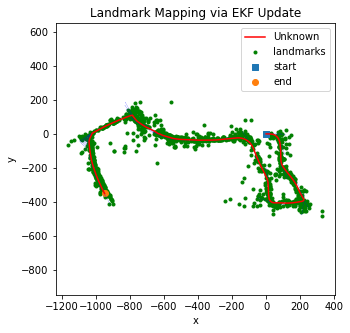

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Landmark Mapping via EKF Update'}, xlabel='x', ylabel='y'>)

In [31]:
downsampledIndices=np.arange(1,map2D.shape[1],10)
downSampledMap=map2D[:,downsampledIndices]
utils.visualize_trajectory_2d(poses,downSampledMap, show_ori=True)